## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
#Load the dataset and take a look of the first few lines
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
#look as the shape of the dataframe
df.shape

(294478, 5)

In [4]:
#Check the unique user_id
df.user_id.nunique()

290584

In [5]:
#Calculate the proportion of users converted
df['converted'].mean()

0.11965919355605512

In [6]:
#Calculate the total rows with mispalced labels
mis_1 = df.query('landing_page == "new_page" & group != "treatment"').count()['user_id']
mis_2 = df.query('landing_page == "old_page" & group != "control"').count()['user_id']
mis_1 + mis_2

3893

In [7]:
#Check if there's any row missing values
df.isnull().values.any()

False

For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  

In [8]:
#Filter the df dataframe to get the new df2 without mismatched data
df2= df[(df['landing_page'] == 'new_page') & (df['group'] == 'treatment') | (df['landing_page'] == 'old_page') & (df['group'] == 'control')]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
#Get the unique user_id in df2
df2.user_id.nunique(), df2.shape

(290584, (290585, 5))

In [11]:
#Get the duplicate
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
#Retrive the duplicates based on the user_id
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
#drop the duplicated row
df2 = df2.drop_duplicates()

The probability of an individual converting regardless of the page they receive:

In [14]:
print("The probability of converted:", df.converted.mean())

The probability of converted: 0.11965919355605512


In [15]:
print("The probability of converted in control group:", df2.query('group == "control"')['converted'].mean())

The probability of converted in control group: 0.1203863045004612


In [16]:
print("The probability of converted in treatment group:", df2.query('group == "treatment"')['converted'].mean())

The probability of converted in treatment group: 0.11880724790277405


In [17]:
print("The probability of converted in control group:", len(df2.query('landing_page == "new_page"'))/len(df2))

The probability of converted in control group: 0.5000636646764286


According to the results, the old control page has a 0.2% higher conversion rate comparing to the new treatment page. However, the results is not practically significant due to such a small difference. The results are not favorable to new treatment page either as the new treatment page actually has a lower conversion rate than the old version. But the naive probability test is far from enough to examine the true statistical significance. Further tests are needed.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$
H_0: p_{new} - p_{old} \leq 0
$$
$$
H_1: p_{new} - p_{old} > 0
$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

The **convert rate** for $p_{new}$ under the null:

In [18]:
#Calculating the conversion rate of the new page
p_new = df2.query('landing_page == "new_page"')['converted'].mean()
print('The convert rate for the new page:', p_new)

The convert rate for the new page: 0.11880724790277405


In [19]:
#Calculating the conversion rate of the old page
p_old = df2.query('landing_page == "old_page"')['converted'].mean()
print('The convert rate for the new page:', p_old)

The convert rate for the new page: 0.1203863045004612


In [20]:
print('The difference between the two conversion rate:', p_new - p_old)

The difference between the two conversion rate: -0.0015790565976871451


In [21]:
#Calculating the mean conversion rate 
p_mean = np.mean([p_new, p_old])
print('The mean conversion rate of p_new and p_old:',p_mean)

The mean conversion rate of p_new and p_old: 0.119596776202


According to the assumption provided above, under the null hypothesis, the p_new and p_old both have the same value, which means: $$ p_{new} = p_{old}$$
Thus, the p_new and p_old should both equal to the mean conversion rate of the dataset ad_data.csv regardless of the page type, which is 0.1196. So that:
$$ p_{new} = 0.1196$$

The **convert rate** for $p_{old}$ under the null: <br><br>

The p_old under the null hypothesis should be as same as p_new, which is 0.1196.

In [22]:
#Get the n_new and n_old
n_new, n_old = df2.landing_page.value_counts()
print('n_new is:',n_new)

n_new is: 145311


In [23]:
print('n_old is:', n_old)

n_old is: 145274


Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
#Simulate the new page converted on the size of the new pages
new_page_converted = np.random.choice([1, 0], size = n_new, p = [p_mean, (1-p_mean)], replace = True)

Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
#Simulate the old page converted on the size of the new pages
old_page_converted = np.random.choice([1, 0], size = n_old, p = [p_mean, (1-p_mean)], replace = True)

Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
#Calculate the sample mean difference
new_page_converted.mean() - old_page_converted.mean()

-0.00033342429828678299

Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
#Generate a sample distribution based on the sample mean difference
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.choice([1,0], size = n_new, p = [p_mean, (1-p_mean)], replace = True)
    old_page_converted = np.random.choice([1,0], size = n_old, p = [p_mean, (1-p_mean)], replace = True)
    p_diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(p_diff)

Plot a histogram of the **p_diffs**. 

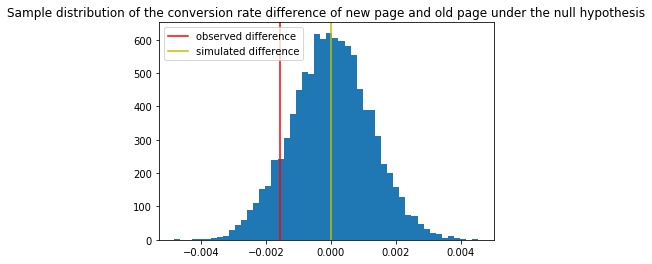

In [28]:
#Plot the histogram
p_diffs = np.array(p_diffs)
plt.hist(p_diffs, bins = 50)
plt.title('Sample distribution of the conversion rate difference of new page and old page under the null hypothesis')
plt.axvline(x = p_new - p_old, color = 'r', label = 'observed difference')
plt.axvline(x = np.mean(p_diffs), color = 'y', label = 'simulated difference')
plt.legend()

In [29]:
#Get the proporation of the p_diffs greater than actual difference
p_val = (p_diffs > (p_new-p_old)).mean()
print('The proportion of p_diffs greater than the actual difference:',p_val)

The proportion of p_diffs greater than the actual difference: 0.9022


The value result of the part j is called p value. It means that assuming the null hypothesis is true, the probability of getting the observed statistics or more extreme favours the alternative hypothesis. In this case, the p value is 0.91, which is high enough for us to consider the null hypothesis is true given if the type I error rate is 5%. This suggests that the new page does not do better than the old page, the implementation of the new landing page can get even worse conversion rate than the old page. 

In [30]:
#import the necessary library and get the convert_new, convert_old, n_old and n_new
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').count()['user_id']
convert_new = df2.query('landing_page == "new_page" & converted == 1').count()['user_id']
n_old = df2[df2['landing_page'] == 'old_page'].count()['user_id']
n_new = df2[df2['landing_page'] == 'new_page'].count()['user_id']

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Use `stats.proportions_ztest` to compute the test statistic and p-value:

In [57]:
#Utilizing the z test to get the z score and p value
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative = 'larger')

In [58]:
z_score, p_value

(-1.3116075339133115, 0.90517370514059103)

Z score measures the number of standard deviation of a data point differ from the mean. According to the above results, we can see that the difference between the mean from the null hypothesis and the observed mean is 1.31 standard deviations. The p value is 0.905, which is higher than 0.05, which indicates that we fail to reject the null hypothesis. The difference in the p value suggests the difference in the hypothesis in parts j. and k.. The null hypothesis for z-test is the conversion rate of the old page equals to the conversion rate of the new page, which indicates the alternative hypothesis is that the coversion rate of the old page is different from the conversion rate of the new page. As the results shown, the p value of the z test is 0.905, which means that we fail to reject the null hypothesis. The result agrees with the findings in part j. and k.. 

<a id='regression'></a>
### Part III - A regression approach

Due to the fact that the dependent variables are categorical variables, it is better for us to use logistic regression than other regression models.

Previous to implementing the regression model. There might be a valuable perspective to consider when analyzing A/B test results. Due to psychological reasons, the change from a old page to a new page may have different effect on different groups of users. There might be change aversion that prevent the old users to like the new page even the new page is indeed better than the old page, which will decrease the conversion rate for the old users in a certain period of time after the change being implemented. The novelty effect may affect the result as well, which means there are certain type of users who love the new changes regardless whether the new page brings positive changes or not. Fortunately, these psychological effects can be reduced or even eliminated after a certain period of time naturally. So it is important to add time variables to the regression model to see the effect of time.

First we want to see the data type of the time and convert it into a more accessible version for analysis.

In [33]:
#Check to see the data type of the dataframe
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [34]:
#Convert the data type to datetime and then parse the date
df2['date'] = pd.to_datetime(df2['timestamp'])
df2['date'] = pd.DatetimeIndex(df2.date).normalize()

In [35]:
#Get the sorted array of date
np.sort(df2.date.unique())

array(['2017-01-02T00:00:00.000000000', '2017-01-03T00:00:00.000000000',
       '2017-01-04T00:00:00.000000000', '2017-01-05T00:00:00.000000000',
       '2017-01-06T00:00:00.000000000', '2017-01-07T00:00:00.000000000',
       '2017-01-08T00:00:00.000000000', '2017-01-09T00:00:00.000000000',
       '2017-01-10T00:00:00.000000000', '2017-01-11T00:00:00.000000000',
       '2017-01-12T00:00:00.000000000', '2017-01-13T00:00:00.000000000',
       '2017-01-14T00:00:00.000000000', '2017-01-15T00:00:00.000000000',
       '2017-01-16T00:00:00.000000000', '2017-01-17T00:00:00.000000000',
       '2017-01-18T00:00:00.000000000', '2017-01-19T00:00:00.000000000',
       '2017-01-20T00:00:00.000000000', '2017-01-21T00:00:00.000000000',
       '2017-01-22T00:00:00.000000000', '2017-01-23T00:00:00.000000000',
       '2017-01-24T00:00:00.000000000'], dtype='datetime64[ns]')

In [36]:
#Get the sorted series of date to see the sample size for each date
df2.date.value_counts().sort_index(axis = 0)

2017-01-02     5712
2017-01-03    13208
2017-01-04    13119
2017-01-05    12932
2017-01-06    13353
2017-01-07    13213
2017-01-08    13387
2017-01-09    13243
2017-01-10    13350
2017-01-11    13361
2017-01-12    13159
2017-01-13    13060
2017-01-14    13148
2017-01-15    13263
2017-01-16    13136
2017-01-17    13155
2017-01-18    13085
2017-01-19    13130
2017-01-20    13213
2017-01-21    13309
2017-01-22    13265
2017-01-23    13349
2017-01-24     7435
Name: date, dtype: int64

In [37]:
#Check to see the data type
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 6 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
date            290585 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 15.5+ MB


From the above array we can see that the dataset recorded 23 consecutive days of the behavior of users. So that there might be changes in the conversion rate over time. We can devide these dates into three different date groups.

In [38]:
#define a function to categorize data
def date_cat(date):
    date = np.datetime64(date)
    if date <= np.datetime64('2017-01-09'):
        return 'Begining'
    elif date <= np.datetime64('2017-01-17'):
        return 'Middle'
    elif date <= np.datetime64('2017-01-24'):
        return 'End'

In [39]:
#Assign each date to a different group
df2['dategroup'] = df2['date'].apply(date_cat)

In [40]:
#Check to see if the function is working properly
df2.head()

,user_id,timestamp,group,landing_page,converted,date,dategroup
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21,End
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12,Middle
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11,Middle
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08,Begining
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21,End


In [41]:
#Assigning dummie variables into the function for further analysis in regression model
df2[['Begining', 'End', 'Middle']] = pd.get_dummies(df2['dategroup'])
df2.head()

,user_id,timestamp,group,landing_page,converted,date,dategroup,Begining,End,Middle
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21,End,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12,Middle,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11,Middle,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08,Begining,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21,End,0,1,0


Use **statsmodels** to fit the regression model specified to see if there is a significant difference in conversion based on which page a customer receives. The following variables are created for the regression model: Intercept, A dummy variable column for which page each user received, which is 1 when an individual receives the **treatment** and 0 if **control**. 

In [42]:
#Add intercept column to the dataframe
df2['intercept'] = 1
group_dummies = pd.get_dummies(df2['group'])
new_df2 = df2.join(group_dummies)
new_df2 = new_df2.rename(columns = {'treatment' : 'ab_page'})
new_df2.head()

,user_id,timestamp,group,landing_page,converted,date,dategroup,Begining,End,Middle,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,2017-01-21,End,0,1,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,2017-01-12,Middle,0,0,1,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,2017-01-11,Middle,0,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,2017-01-08,Begining,1,0,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,2017-01-21,End,0,1,0,1,1,0


Use **statsmodels** to import the regression model.

In [43]:
#Fit into the regression model
lm = sm.Logit(new_df2['converted'], new_df2[['intercept','ab_page']])
reg_lm = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [44]:
# Export the regression model summary
reg_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:               8.085e-06
Time:                        02:08:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

The p value associated with ab_page is 0.19, which is similar to the p value I found in part II in the z test. Due to the difference in application of the logistic regression model, the null Comparing to the null hypothesis and alternative hypothesis in part II, the null hypothesis associated with this logistic regression model is the change of page does not have relation with the change of conversion rate. To my understanding, this hypothesis can be translated to the conversion rate of the old page and the conversion rate of the new page are equal, which explains that why are these two p values so similar.

Typically, the A\B test result of a website can be biased by some psychological effect of different user group. This including the change aversion and novelty effect. The change aversion might prevent the old users to like the new page even the new page is indeed better than the old page, which will decrease the conversion rate for the old users in a certain period of time after the change being implemented. The novelty effect may affect the result as well, which means there are certain type of users who love the new changes regardless whether the new page brings positive changes or not. So it is wise to consider the time influence on the conversion rate.

There are also disadvantages when adding additional terms into regression model. There might be correlation between the additional terms added and it can cause multicollinearity. Multicolinerity can harm the predictive power of a regression model in many cases. So when considering adding new variables, analyst should be careful about the correlation between each explanatory variables.

In [45]:
#fit the model with the dategroup dummie variables
lm_2 = sm.Logit(new_df2['converted'], new_df2[['intercept', 'Middle', 'End', 'ab_page']])
reg_lm2 = lm_2.fit()
reg_lm2.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:               1.457e-05
Time:                        02:08:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.3764
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9976      0.011   -175.304      0.000      -2.020      -1.975
Middle         0.0108      0.014      0.790      0.430      -0.016       0.038
End            0.0165      0.014      1.146      0.252      -0.012       0.045
ab_page       -0.0150      0.011     -1.310      0.190      -0.037       0.007
==============================================================================
"""

In [46]:
#Exponentiate the coefficient of each variable
np.exp(reg_lm2.params)

intercept    0.135654
Middle       1.010865
End          1.016598
ab_page      0.985131
dtype: float64

According to the result of the logistic regression model including dategroup dummie variables, we can see that on average, after the first 8 days, the users are 1.011 times more likely to be converted than in the beginning 8 days. At the end of the period, the users on average are 1.017 times more likely to be converted. Unfortunately, although the result of the logistic regression model has indicated a higher probability of converting a user based on time passes, the implementation of the new page is neither practically significant nor statistically significant to generate higher conversion rate over time. 

Regardless of the result in this example. We can see that the conversion rate is slightly higher in the later time period than in the very beginning. So we might consider the influence of change aversion does play a role in this A/B testing. 

We can further examine the effect of the geographic on the test result by adding an effect based on which country a user lives by loading the `countries.csv`.

In [47]:
#Load the country data and join the country data into the df2 for further analysis
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(new_df2.set_index('user_id'), how='inner')

In [48]:
#Look at the first few lines of the new dataframe
df_new.head()

,country,timestamp,group,landing_page,converted,date,dategroup,Begining,End,Middle,intercept,control,ab_page
user_id,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,2017-01-19,End,0,1,0,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,2017-01-16,Middle,0,0,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,2017-01-19,End,0,1,0,1,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,2017-01-12,Middle,0,0,1,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,2017-01-18,End,0,1,0,1,0,1


In [52]:
### Create the necessary dummy variables
country_dummies = pd.get_dummies(df_new['country'])
df_new = df_new.join(country_dummies)

In [53]:
df_new.head()

,country,timestamp,group,landing_page,converted,date,dategroup,Begining,End,Middle,intercept,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,2017-01-19,End,0,1,0,1,0,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,2017-01-16,Middle,0,0,1,1,0,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,2017-01-19,End,0,1,0,1,1,0,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,2017-01-12,Middle,0,0,1,1,0,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,2017-01-18,End,0,1,0,1,0,1,0,0,1


In [54]:
### Fit Linear Model And Obtain the Results
lm_country = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
reg_country = lm_country.fit()

Optimization terminated successfully.
         Current function value: 0.366110
         Iterations 6


In [55]:
#Get the summary of the regression model
reg_country.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290587
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            3
Date:                Sun, 18 Feb 2018   Pseudo R-squ.:               2.326e-05
Time:                        02:15:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1756
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.248      0.000      -2.082      -1.978
ab_page       -0.0150      0.011     -1.309      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.075      -0.005       0.106
US             0.0407      0.027      1.515      0.130      -0.012       0.093
==============================================================================
"""

In [56]:
#Exponentiate the coefficient to see the influence of the country variable on the conversion rate
np.exp(reg_country.params)

intercept    0.131333
ab_page      0.985145
UK           1.051944
US           1.041582
dtype: float64

According to the results, on average, the users from UK are 1.05 times more likely to be converted than users from Canada, and the users from US on average are 1.04 times more likely to be converted than users from Canada. The p values for each country are 0.075 and 0.130 respectively. Although the variables are not statistically significant to support the above conclusion, the influences of the country have lower p values than the ab_page variable.

<a id='conclusions'></a>
## Conclusions

As per hypothesis test and logistic regression model suggested, there's no statistical significant evidences that support the implementation of the new page has higher conversion rate of the old version. From the histogram in the part II, we can also see that the new page might even has worse conversion rate than the old one. 

Regarding the time factor and country factor, the result of logistic regression model may have indicated that some variables may have higher probability than one another, but according to the summary of logistic regression model, there are no statistical significant evidences that support the time period and country variables have influence on the conversion rate. 

In a word, the variables in the A\B test result does not demonstrate statistically significance. It is even possible that the new page has slight lower conversion rate than the old version. I would recommend the company invest more in the website design and do the A\B test again. Reading from the result, the new page might have only changed little from the old page, which explains why there is such little change in the conversion rate.

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.